## Bagging with Random Attribute Selection

In [1]:
import urllib.request, urllib.error, urllib.parse
import numpy
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import random
from math import sqrt
import matplotlib.pyplot as plot

In [2]:
#read data into iterable
target_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = urllib.request.urlopen(target_url)

xList = []
labels = []
names = []
firstLine = True
for line in data:
    if firstLine:
        names = line.decode().strip().split(";")
        firstLine = False
    else:
        #split on semi-colon
        row = line.decode().strip().split(";")
        #put labels in separate array
        labels.append(float(row[-1]))
        #remove label from row
        row.pop()
        #convert row to floats
        floatRow = [float(num) for num in row]
        xList.append(floatRow)

nrows = len(xList)
ncols = len(xList[0])

In [3]:
#take fixed test set 30% of sample
random.seed(1)  #set seed so results are the same each run
nSample = int(nrows * 0.30)
idxTest = random.sample(range(nrows), nSample)
idxTest.sort()
idxTrain = [idx for idx in range(nrows) if not(idx in idxTest)]

#Define test and training attribute and label sets
xTrain = [xList[r] for r in idxTrain]
xTest = [xList[r] for r in idxTest]
yTrain = [labels[r] for r in idxTrain]
yTest = [labels[r] for r in idxTest]

In [4]:
#train a series of models on random subsets of the training data
#collect the models in a list and check error of composite as list grows

#maximum number of models to generate
numTreesMax = 30

#tree depth - typically at the high end
treeDepth = 12

#pick how many attributes will be used in each model.
# authors recommend 1/3 for regression problem
nAttr = 4

#initialize a list to hold models
modelList = []
indexList = []
predList = []
nTrainRows = len(yTrain)

for iTrees in range(numTreesMax):

    modelList.append(DecisionTreeRegressor(max_depth=treeDepth))

    #take random sample of attributes
    idxAttr = random.sample(range(ncols), nAttr)
    idxAttr.sort()
    indexList.append(idxAttr)

    #take a random sample of training rows
    idxRows = []
    for i in range(int(0.5 * nTrainRows)):
        idxRows.append(random.choice(range(len(xTrain))))
    idxRows.sort()

    #build training set
    xRfTrain = []
    yRfTrain = []

    for i in range(len(idxRows)):
        temp = [xTrain[idxRows[i]][j] for j in idxAttr]
        xRfTrain.append(temp)
        yRfTrain.append(yTrain[idxRows[i]])

    modelList[-1].fit(xRfTrain, yRfTrain)

    #restrict xTest to attributes selected for training
    xRfTest = []
    for xx in xTest:
        temp = [xx[i] for i in idxAttr]
        xRfTest.append(temp)

    latestOutSamplePrediction = modelList[-1].predict(xRfTest)
    predList.append(list(latestOutSamplePrediction))

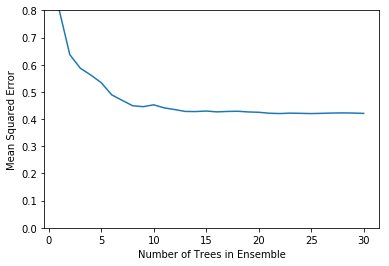

Minimum MSE
0.42028140817408133


In [5]:
#build cumulative prediction from first "n" models
mse = []
allPredictions = []
for iModels in range(len(modelList)):

    #add the first "iModels" of the predictions and multiply by eps
    prediction = []
    for iPred in range(len(xTest)):
        prediction.append(sum([predList[i][iPred] for i in range(iModels + 1)]) / (iModels + 1))

    allPredictions.append(prediction)
    errors = [(yTest[i] - prediction[i]) for i in range(len(yTest))]
    mse.append(sum([e * e for e in errors]) / len(yTest))


nModels = [i + 1 for i in range(len(modelList))]

plot.plot(nModels,mse)
plot.axis('tight')
plot.xlabel('Number of Trees in Ensemble')
plot.ylabel('Mean Squared Error')
plot.ylim((0.0, max(mse)))
plot.show()

print('Minimum MSE')
print(min(mse))

#printed output

#Depth 1
#Minimum MSE
#0.52666715461

#Depth 5
#Minimum MSE
#0.426116327584

#Depth 12
#Minimum MSE
#0.38508387863